# Popular Data Science Questions

In this scenario, you're working for a company that creates data science content, be it books, online articles, videos or interactive text-based platforms like Dataquest.

You're tasked with figuring out what is best content to write about. Because you took this course, you know that given the lack of instructions there's some leeway in what "best" means here.

Since you're passionate about helping people learn, you decide to scower the internet in search for the answer to the question "What is it that people want to learn about in data science?" (as opposed to determining the most profitable content, for instance).

Thinking back to your experience when you first started learning programming, it occurs to you that if you wanted to figure out what programming content to write, you could consult Stack Overflow (a question and answer website about programming) and see what kind of content is more popular.

The fact that DSSE https://stackexchange.com/sites?view=list#percentanswered https://datascience.stackexchange.com is a data science dedicated site (contrarily to the others), coupled with it having a lot of an unanswered questions, makes it an ideal candidate for this investigation. DSSE will be the focus of this guided project.

---

- What kind of questions are welcome on this site?
 - ML, Python, Neural Networks, Deep Learning ...
- What, other than questions, does the site's home subdivide into?
 - Tags, Users and Unanswered
 - Does any of them look useful towards our goal?
  - Most likely Tags
- What information is available in each post?
 - Votes, Timestamp, User, Tags, Answers
- Explore some of the questions that were asked.
- Try asking a couple of questions on any of Stack Exchange sites to get a better feel for how the sites operate.

---

- Explore Data Science Stack Exchange's data model.
 - Investigate a few of the tables, especially those whose names sound more promising;
 - Write a few queries to get a feel for the data;
 ```
 select top 10 Id, Title, Score, ViewCount, AnswerCount from Posts
order by AnswerCount desc;
 ```
- In a markdown cell, write about what tables look more promising towards finding the most popular content.
 - Posts, Tags, eventually Badges

## Getting the Data
https://data.stackexchange.com/datascience/query/new

```
SELECT PostTypeId, COUNT(*) as NrOfPosts
  FROM posts
  WHERE CreationDate BETWEEN '2019-01-01' AND '2019-12-31'
 GROUP BY PostTypeId;
```

|PostTypeId|NrOfPosts|
|---|---|
|1|8642|
|2|7768|
|4|91|
|5|91|
|6|8|

### Run a query against the SEDE DSSE database that extracts the columns listed above for all the questions in 2019
```
SELECT Id, PostTypeId, CreationDate, Score, ViewCount, Tags, AnswerCount, FavoriteCount
  FROM posts
  WHERE CreationDate BETWEEN '2019-01-01' AND '2019-12-31'
```

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
%matplotlib inline
import seaborn as sns
import re
from itertools import islice

In [2]:
df = pd.read_csv("2019_questions.csv")

- Explore the data. Try to answer a few of these questions in a markdown cell:
 - How many missing values are there in each column?
 - Can we fix the missing values somehow?
 - Are the types of each column adequate?
 - What can we do about the Tags column?

In [3]:
# How many missing values are there in each column?
df.isnull().sum()

Id                   0
PostTypeId           0
CreationDate         0
Score                0
ViewCount         7958
Tags              7958
AnswerCount       7958
FavoriteCount    15152
dtype: int64

In [4]:
# Can we fix the missing values somehow?
df.ViewCount.fillna(0, inplace=True)

In [5]:
df.AnswerCount.fillna(0, inplace=True)
df.FavoriteCount.fillna(0,inplace=True)

In [6]:
df.Tags.value_counts()

<machine-learning>                                  114
<python><pandas>                                     58
<python>                                             53
<r>                                                  38
<tensorflow>                                         36
                                                   ... 
<math><simulation><monte-carlo>                       1
<scikit-learn><dataframe><pipelines>                  1
<python><feature-engineering><anomaly-detection>      1
<nlp><named-entity-recognition><spacy><ml>            1
<r><data><code>                                       1
Name: Tags, Length: 6341, dtype: int64

In [7]:
df.Tags = df.Tags.str.replace("^<|>$", "").str.split("><")

In [8]:
df.Tags.fillna("None", inplace=True)

In [9]:
df.Tags.values

array(['None', 'None', 'None', ...,
       list(['bigdata', 'apache-spark', 'dataframe', 'scala']),
       list(['machine-learning']), list(['classification', 'churn'])],
      dtype=object)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16600 entries, 0 to 16599
Data columns (total 8 columns):
Id               16600 non-null int64
PostTypeId       16600 non-null int64
CreationDate     16600 non-null object
Score            16600 non-null int64
ViewCount        16600 non-null float64
Tags             16600 non-null object
AnswerCount      16600 non-null float64
FavoriteCount    16600 non-null float64
dtypes: float64(3), int64(3), object(2)
memory usage: 1.0+ MB


In [11]:
df.CreationDate = pd.to_datetime(df.CreationDate)
df.ViewCount = df.ViewCount.astype(int)
df.AnswerCount = df.AnswerCount.astype(int)
df.FavoriteCount = df.FavoriteCount.astype(int)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16600 entries, 0 to 16599
Data columns (total 8 columns):
Id               16600 non-null int64
PostTypeId       16600 non-null int64
CreationDate     16600 non-null datetime64[ns]
Score            16600 non-null int64
ViewCount        16600 non-null int64
Tags             16600 non-null object
AnswerCount      16600 non-null int64
FavoriteCount    16600 non-null int64
dtypes: datetime64[ns](1), int64(6), object(1)
memory usage: 1.0+ MB


In [13]:
df.Tags.value_counts()

None                                                   7958
[machine-learning]                                      114
[python, pandas]                                         58
[python]                                                 53
[r]                                                      38
                                                       ... 
[machine-learning, python, time-series, statistics]       1
[classification, nlp, text]                               1
[dataset, ml]                                             1
[accuracy, semi-supervised-learning]                      1
[python, neural-network, keras, scikit-learn]             1
Name: Tags, Length: 6342, dtype: int64

In [20]:
corr = df.corr()

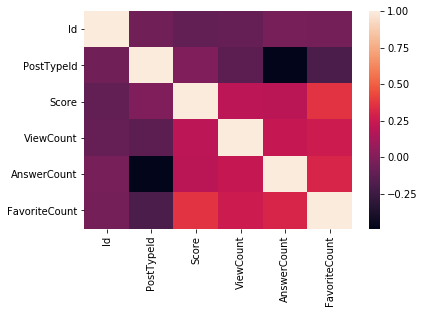

In [21]:
sns.heatmap(corr)
plt.show()

We now focus on determining the most popular tags. We'll do so by considering two different popularity proxies: for each tag we'll count how many times the tag was used, and how many times a question with that tag was viewed.

We could take into account the score, or whether or not a question is part of someone's favorite questions. These are all reasonable options to investigate; but we'll limit the focus of our research to counts and views for now.

## Count how many times each tag was used.

In [22]:
df.head()

,Id,PostTypeId,CreationDate,Score,ViewCount,Tags,AnswerCount,FavoriteCount
0,52361,2,2019-05-22 02:15:55,1,0,None,0,0
1,52362,2,2019-05-22 02:29:42,0,0,None,0,0
2,52364,2,2019-05-22 03:17:51,1,0,None,0,0
3,52365,2,2019-05-22 03:21:25,1,0,None,0,0
4,52366,1,2019-05-22 03:24:53,0,6,"[machine-learning, image-recognition]",0,0


In [49]:
tag_count = {}
for row in df.Tags.loc[df.Tags.notnull()]:
    for lists in row:
        if lists in tag_count:
            tag_count[lists] += 1
        else:
            tag_count[lists] = 1
        

del tag_count["N"]
del tag_count["o"]
del tag_count["n"]
del tag_count["e"]

tag_count

{'machine-learning': 2642,
 'image-recognition': 84,
 'natural-language-process': 120,
 'r': 264,
 'forecast': 33,
 'lstm': 386,
 'rnn': 146,
 'keras': 919,
 'object-detection': 106,
 'text': 40,
 'ocr': 25,
 'tensorflow': 573,
 'neural-network': 1038,
 'deep-learning': 1190,
 'classification': 669,
 'binary': 26,
 'gan': 85,
 'hyperparameter': 40,
 'generative-models': 46,
 'parameter': 4,
 'data': 204,
 'visualization': 125,
 'dimensionality-reduction': 68,
 'tsne': 15,
 'time-series': 450,
 'bigdata': 91,
 'python': 1785,
 'reinforcement-learning': 198,
 'dqn': 34,
 'linear-regression': 172,
 'orange': 63,
 'evaluation': 64,
 'powerbi': 10,
 'cnn': 484,
 'accuracy': 89,
 'forecasting': 83,
 'data-mining': 214,
 'unsupervised-learning': 108,
 'java': 14,
 'gradient-descent': 98,
 'pytorch': 173,
 'predictive-modeling': 262,
 'data-science-model': 183,
 'model-selection': 57,
 'caffe': 7,
 'logistic-regression': 152,
 'classifier': 18,
 'json': 9,
 'random-forest': 157,
 'optimization

In [50]:
most_used = pd.DataFrame.from_dict(tag_count, orient="index")
most_used.rename(columns={0: "Count"}, inplace=True)
most_used.head(10)

,Count
machine-learning,2642
image-recognition,84
natural-language-process,120
r,264
forecast,33
lstm,386
rnn,146
keras,919
object-detection,106
text,40


In [51]:
# sort by value:
#{k: v for k, v in sorted(tag_count.items(), key=lambda item: item[1])}
#tag_count

most_used.sort_values(by="Count",ascending=False, inplace=True)
most_used.head(10)

,Count
machine-learning,2642
python,1785
deep-learning,1190
neural-network,1038
keras,919
classification,669
tensorflow,573
scikit-learn,530
cnn,484
nlp,484


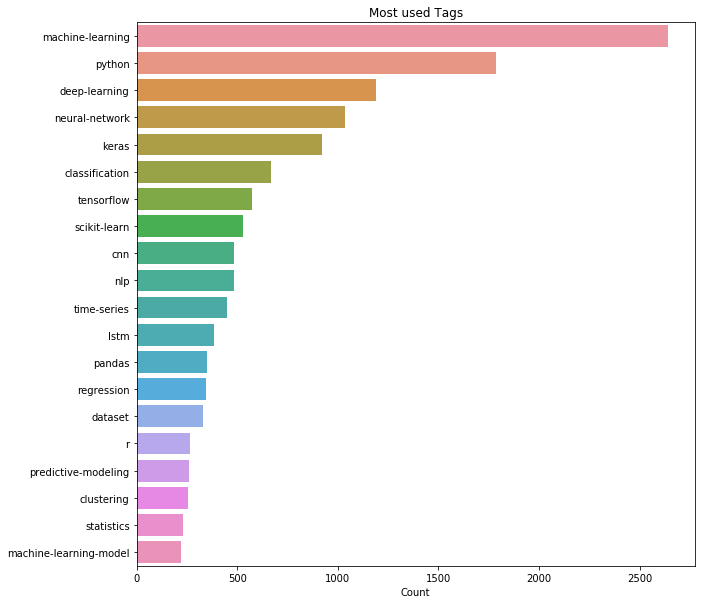

In [54]:
def take(n, iterable):
    "Return first n items of the iterable as a list"
    return dict(islice(iterable, n))

#top_used = take(20, tag_count.items())
#top_used_keys = top_used.keys()
#top_used_values = top_used.values()

#list(top_used_keys)
#list(top_used_values)


#top_used = pd.DataFrame(top_used_values, top_used_keys)
#top_used.sort_values(by=[0],inplace=True, ascending=False)
top_used = most_used.head(20)

fig, ax = plt.subplots(figsize=(10,10))
ax = sns.barplot(x=top_used.Count, y=top_used.index)
plt.title("Most used Tags")
plt.show()

## Count how many times each tag was viewed.

In [56]:
df.sort_values(by="ViewCount", ascending=False).head(20)

,Id,PostTypeId,CreationDate,Score,ViewCount,Tags,AnswerCount,FavoriteCount
12628,45314,1,2019-02-09 18:24:50,6,47596,"[python, pandas]",3,2
7353,48049,1,2019-03-26 17:18:06,6,36912,"[python, dataframe, csv, data-formats]",2,2
14206,45165,1,2019-02-06 13:29:24,18,34882,"[machine-learning, neural-network, deep-learni...",4,3
14051,56668,1,2019-07-31 10:08:51,6,21734,"[data-mining, pandas]",3,0
7787,54214,1,2019-06-21 11:48:16,1,16346,"[scikit-learn, pandas, numpy]",1,0
2437,46437,1,2019-03-01 05:23:54,4,14301,"[pandas, dataframe, excel, data.table]",3,0
11307,44871,1,2019-01-31 15:57:53,0,14202,"[python, computer-vision, opencv]",2,0
1598,53048,1,2019-06-01 14:23:37,2,13026,"[machine-learning, python]",1,0
13709,51065,1,2019-04-28 14:43:17,20,10623,"[nlp, encoding, attention-mechanism, transformer]",3,8
7342,48035,1,2019-03-26 14:57:22,3,10290,"[python, matplotlib, seaborn]",2,3
